**Reference**:

https://towardsdatascience.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface-94b2ed6f798f

https://predictivehacks.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface/


# Don't normalize the data 

# Linear Regression 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import Dataset,load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers.utils import logging
logging.set_verbosity_error()

In [6]:
! pwd

/Users/yousef/code/thesis-nlp


In [73]:

data_file = '/Users/yousef/code/thesis-nlp/dataset/incident-ohlc-v06-scalar.csv'
df_o = pd.read_csv(data_file,parse_dates=['date'],index_col=['date'])
df_o.sort_index(inplace=True)
# df['date'] = df.index
# data_columns =  ['w_open', 'w_high', 'w_low', 'w_close', 'new', 'started','done', 'dayofweek', 'dayofmonth', 'dayofyear', 'target', 'y_ystrdy']
data_columns =  ['w_open', 'w_high', 'w_low', 'w_close', 'new', 'started','done', 'dayofweek', 'dayofmonth', 'dayofyear', 'target', 'y_ystrdy']

df_o = df_o[data_columns].copy()
# display(df.head())
df = pd.DataFrame()
df['label']= df_o['target']
df['text']= ''
for col in data_columns[:-2]:
    df_o[col] = df_o[col].apply(lambda x: f'{x:.0f}')
    df['text'] = df['text'] + f' {col} ' + df_o[col].astype(str)

df = df.iloc[1:]

display(df['text'][0])
display(df.head(2))

' w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14'

,label,text
date,,
2010-01-14,1.0,w_open 0 w_high 1 w_low 0 w_close 1 new 3 sta...
2010-01-15,1.0,w_open 1 w_high 1 w_low 1 w_close 1 new 1 sta...


## Create AutoTokenizer

In [65]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Pandas To Dataset

In [112]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

columns = ['text','label']
def make_dataset(dataset, iloc_from, iloc_to):
    df_ = dataset[columns].iloc[iloc_from:iloc_to]  
    # df_.reset_index(inplace=True,drop=True)
    return df_

df_nlp = make_dataset(df, 0,len(df))
display(df_nlp.head(3))

dataset = Dataset.from_pandas(df_nlp[columns],preserve_index=False) 
dataset = dataset.train_test_split(test_size=0.3) 

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

dataset

,text,label
date,,
2010-01-14,w_open 0 w_high 1 w_low 0 w_close 1 new 3 sta...,1.0
2010-01-15,w_open 1 w_high 1 w_low 1 w_close 1 new 1 sta...,1.0
2010-01-16,w_open 1 w_high 1 w_low 1 w_close 1 new 0 sta...,1.0


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1015
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 436
    })
})

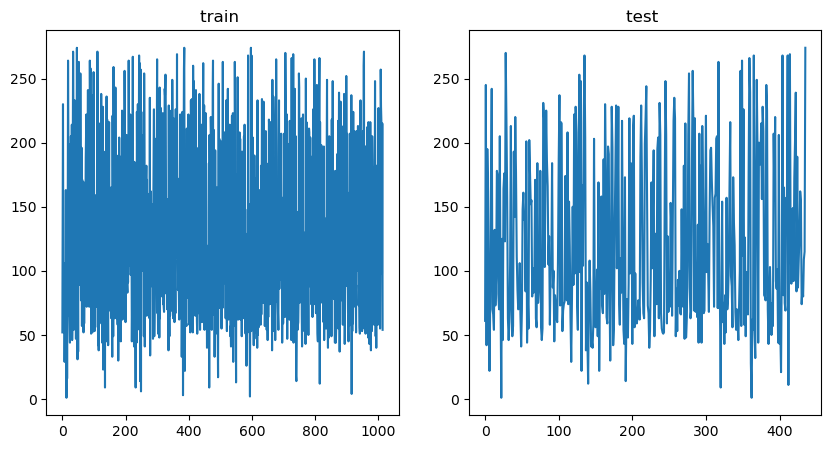

In [113]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))

axs[0].plot(dataset['train']['label'],label='train')
axs[1].plot(dataset['test']['label'],label='train')
axs[0].title.set_text('train ')
axs[1].title.set_text('test ')


## Tokenization & How To Add New Tokens


In [114]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

for x in data_columns:
        tokenizer.add_tokens(x)
        
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# add separators : , - , at, on 
# add hour, min as  00 , 01 , 59
# add 2010, 2011

loading configuration file config.json from cache at /Users/yousef/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/yousef/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /Users/yousef/.cache/huggingface/hub/models--distil

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Test Tokenization

In [115]:
text = df_nlp["text"][0]
tokens = tokenizer(text)['input_ids']
actual_tokens = [tokenizer.decode(i) for i in tokens]

print(f'text  :{text} \ntokens:{tokens} \nactual token:{actual_tokens}')

text  : w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14 
tokens:[101, 30522, 1014, 30523, 1015, 30524, 1014, 30525, 1015, 2047, 1017, 2318, 1015, 2589, 1014, 30526, 1017, 30527, 2403, 30528, 2403, 102] 
actual token:['[CLS]', 'w_open', '0', 'w_high', '1', 'w_low', '0', 'w_close', '1', 'new', '3', 'started', '1', 'done', '0', 'dayofweek', '3', 'dayofmonth', '14', 'dayofyear', '14', '[SEP]']


## Fine-Tuning The Model

In [116]:
from transformers import AutoModelForSequenceClassification

# num_labels =1 means regression
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=3,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False,
                                  report_to="none"
                                  )

loading configuration file config.json from cache at /Users/yousef/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /Users/yousef/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_m

### Metrics Function


In [117]:
from datasets import load_metric
from sklearn.metrics import mean_squared_error
import evaluate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # rmse = mean_squared_error(labels, predictions, squared=False)
    rmse = mean_squared_error(labels, predictions, squared=True)
    return {"rmse": rmse}

def compute_metrics_mape(eval_pred):
    predictions, labels = eval_pred
    mape = mape_metric.compute(predictions=predictions, references=labels)
    return {"mape": mape}

### Train The Model

In [118]:
from transformers import TrainingArguments, Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/yousef/miniforge3/envs/mlp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1015
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 192
  Number of trainable parameters = 66960385


Epoch,Training Loss,Validation Loss


TypeError: must be real number, not NoneType

# Train and test chart and metrics

In [109]:
predictions_test = trainer.predict(tokenized_datasets["test"])
predictions_train = trainer.predict(tokenized_datasets["train"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 70
  Batch size = 16


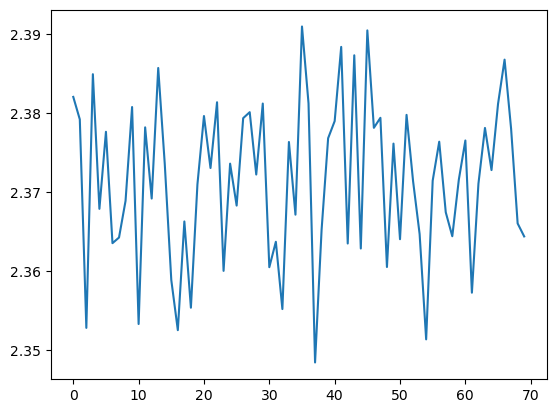

In [110]:
plt.plot(data[0],label='train')

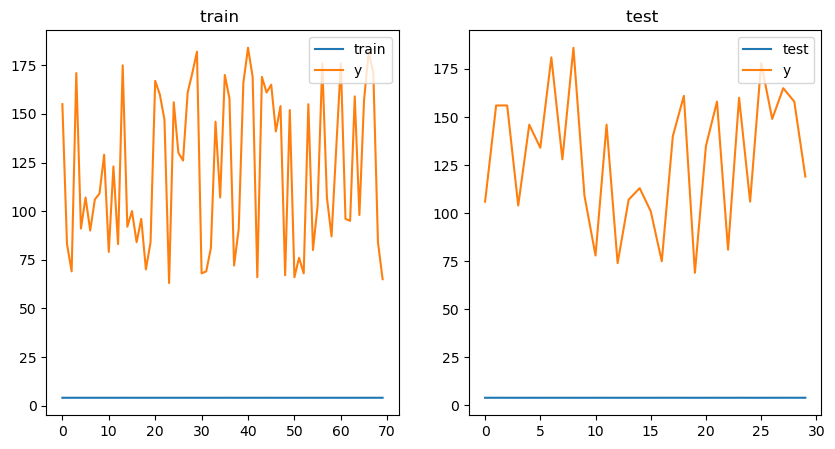

In [111]:
data = [predictions_train.predictions,predictions_test.predictions]
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))

axs[0].plot(data[0],label='train')
axs[0].plot(dataset["train"]['label'],label='y')
axs[0].title.set_text('train ')
axs[0].legend(loc='upper right')


axs[1].plot(data[1],label='test')
axs[1].plot(dataset["test"]['label'],label='y')
axs[1].title.set_text('test ')
axs[1].legend(loc='upper right')


In [14]:
print(f'key\t\t train.metric \t test.metrics')

for key in list(predictions_test.metrics.keys())[:2]:
    print(f'{key} \t\t{predictions_train.metrics[key]:0.3f} \t\t{predictions_test.metrics[key]:0.3f}')

key		 train.metric 	 test.metrics
test_loss 		0.066 		0.073
test_rmse 		0.258 		0.270


## Save And Load The Pre-Trained Model And Tokenizer


In [147]:
# save the model/tokenizer

model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

# load the model/tokenizer

from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin
tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json
loading configuration file model/config.json
Model config DistilBertConfig {
  "_name_or_path": "model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30581
}

loading weights file model/pytorch_model.bin
All mod

##  Use The Model

In [148]:
from transformers import Trainer
trainer = Trainer(model=model)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True) 

def pipeline_prediction(text):
    df=pd.DataFrame({'text':[text]})
    dataset = Dataset.from_pandas(df,preserve_index=False) 
    tokenized_datasets = dataset.map(tokenize_function)
    raw_pred, _, _ = trainer.predict(tokenized_datasets) 
    return(raw_pred[0][0])

pipeline_prediction("🚨 Get 50% now!")

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.49922305